# House Prices Kaggle challenge

*Last update: 24/10/2022*

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges to predict the final price of each home. Our target or dependant variable is "SalePrice".

The challenge website is: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

The evaluation is done with the root mean squared logarithmic error (RMSLE), which is mainly used when predictions have large deviations and we don't want to punish predictions as much as with mean squared error.

I wanted to use this challenge to try different things, to experiment with the data, and mainly to explore polynomial regression, focusing in the Ridge model that adds L2 regularization while using some evaluation techniques learnt from Andrew's Ng course: graphs for comparing the training and testing errors, and the learning curve to detect overfitting. 

I also explored using random forest for regression, and compared it with the previous model.

The results in the Kaggle website where (again, evaluating with the RMSLE):
- Polynomial regression: 0.16235
- Random forest: 0.17069

# Table of contents

* [Importing libraries and data](#import)

* [Understanding the data - EDA](#understanding)

* [Preparing the data](#preparing)

* [Modelling](#modelling)
    * [Polynomial regression](#polynomial)
    * [Random forest](#random)

### Importing libraries and data <a class="anchor" id="import"></a>

In [318]:
## Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 15
pd.options.display.max_columns = 85

import scipy.stats as ss
from scipy.stats import chi2_contingency
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [319]:
## Importing data
df_houses = pd.read_csv('house-prices-advanced-regression-techniques/train.csv') # Set to train the model
df_challenge = pd.read_csv('house-prices-advanced-regression-techniques/test.csv') # Set for the challenge, in which predictions need to be made

## Understanding the data - Exploratory Data Analysis <a class="anchor" id="understanding"></a>

A quick Internet search shows what are considered the most relevant factors when pricing a house:

   1. *Neighbourhood*: some key factors are proximity to jobs, schools and public transportation. Also important are local shops, entertainment, parking and crime rate.

   2. *Home's age and condition*: particularly if the house needs a lot of work!

   3. *Property size*: Size matters, although they key factor is the amount of livable space.

Going through the features of the dataset, the ones that seemingly fit best with the previous factors are:

- Neighborhood: Physical locations within Ames city limits.
- MSZoning: Identifies the general zoning classification of the sale.

- OverallQual: Rates the overall material and finish of the house.
- YearBuilt: Original construction date.

- LotArea: Lot size in square feet.
- GrLivArea: Above grade (ground) living area square feet.

Before anything else, what are the characteristics of our target, "SalePrice": the property's sale price in dollars?

In [320]:
df_houses[["SalePrice"]].describe()

SalePrice
count    1460.000000
mean   180921.195890
std     79442.502883
min     34900.000000
25%    129975.000000
50%    163000.000000
75%    214000.000000
max    755000.000000

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

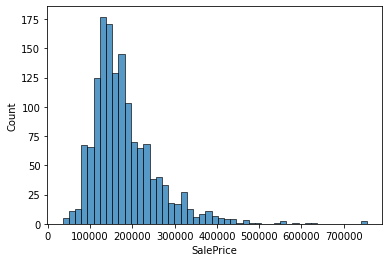

In [321]:
sns.histplot(data=df_houses, x="SalePrice")

The distribution is not normal, with some skewedness to the left; there are no zero values, with a mean of close to 181000 dollars, and there are a pair of values over 700000 which seemed like outliers but at least for now I will keep.

Next, I would like to have an understanding of the size of the data and the number of features:

In [322]:
df = df_houses
df = df.set_index("Id")
print(f"The training set has {df.shape[0]} samples and {df.shape[1]-1} features")
print(f"The challenge set has {df_challenge.shape[0]} samples")
df.head()

The training set has 1460 samples and 79 features
The challenge set has 1459 samples


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                       
1        Norm     1Fam     2Story            7            5       2003   
2        Norm     1Fam     1Story            6            8       1976   
3        Norm     1Fam     2Story            7            5       2001   
4        Norm     1Fam     2Story            7            5       1915   
5        Norm     1Fam     2Story            8            5       2000   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                       
1           2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2           1976     Gable  CompShg     MetalSd     MetalSd       None   
3           2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4           1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
5           2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                             
1        196.0        Gd        TA      PConc       Gd       TA           No   
2          0.0        TA        TA     CBlock       Gd       TA           Gd   
3        162.0        Gd        TA      PConc       Gd       TA           Mn   
4          0.0        TA        TA     BrkTil       TA       Gd           No   
5        350.0        Gd        TA      PConc       Gd       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                             
1           GLQ         706          Unf           0        150          856   
2           ALQ         978          Unf           0        284         1262   
3           GLQ         486          Unf           0        434          920   
4           ALQ         216          Unf           0        540          756   
5           GLQ         655          Unf           0        490         1145   

   Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                             
1     GasA        Ex          Y      SBrkr       856       854             0   
2     GasA        Ex          Y      SBrkr      1262         0             0   
3     GasA        Ex          Y      SBrkr       920       866             0   
4     GasA        Gd          Y      SBrkr       961       756             0   
5     GasA        Ex          Y      SBrkr      1145      1053             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                            
1        1710             1             0         2         1             3   
2        1262             0             1  

In [323]:
#df.info()

The previous dataframe had some missing values, so I wonder: are there any features missing lots of values?

<AxesSubplot:title={'center':'Total of missing values'}>

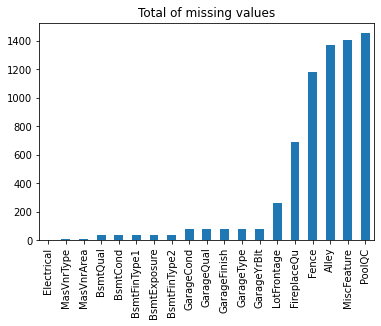

In [324]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(title="Total of missing values")

The features with most missing values do not seem particularly relevant in order to predict the price, so I will remove all the ones with more than 15% of missing values:

In [325]:
s_nan = df.isnull().sum()*100/df.shape[0]
s_nan = s_nan[s_nan > 0]
print("Features with more than 15% of missing values (in percentage)")
s_nan.loc[s_nan > 15]

Features with more than 15% of missing values (in percentage)


LotFrontage    17.739726
Alley          93.767123
FireplaceQu    47.260274
PoolQC         99.520548
Fence          80.753425
MiscFeature    96.301370
dtype: float64

In [326]:
## Removal of features with more than 15% of missing values
df = df.drop(["LotFrontage","Alley","FireplaceQu","PoolQC","Fence","MiscFeature"], axis=1)

print(f"There are {df.shape[1]-1} features left. Other features with missing data are:")
s_nan2 = df.isnull().sum()*100/df.shape[0]
s_nan2 = s_nan2[s_nan2 > 0]
s_nan2 = s_nan2.to_frame()
s_nan2.rename(columns = {0:"% of missing values"},inplace=True)
s_nan2.transpose()

There are 73 features left. Other features with missing data are:


MasVnrType  MasVnrArea  BsmtQual  BsmtCond  BsmtExposure  \
% of missing values    0.547945    0.547945  2.534247  2.534247       2.60274   

                     BsmtFinType1  BsmtFinType2  Electrical  GarageType  \
% of missing values      2.534247       2.60274    0.068493    5.547945   

                     GarageYrBlt  GarageFinish  GarageQual  GarageCond  
% of missing values     5.547945      5.547945    5.547945    5.547945

In order to understand better the data, I wonder: which unique values each feature has? This information is useful as a reference.

In [327]:
for column in df:
    unique_values = df[column].unique()
    number_values = len(unique_values)
    if number_values <= 10: # Only print if unique values are less than 11
        print(f"The {column} feature has {number_values} values, which are:{unique_values}")
    else :
        print(f"The {column} feature has {number_values} values")

The MSSubClass feature has 15 values
The MSZoning feature has 5 values, which are:['RL' 'RM' 'C (all)' 'FV' 'RH']
The LotArea feature has 1073 values
The Street feature has 2 values, which are:['Pave' 'Grvl']
The LotShape feature has 4 values, which are:['Reg' 'IR1' 'IR2' 'IR3']
The LandContour feature has 4 values, which are:['Lvl' 'Bnk' 'Low' 'HLS']
The Utilities feature has 2 values, which are:['AllPub' 'NoSeWa']
The LotConfig feature has 5 values, which are:['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
The LandSlope feature has 3 values, which are:['Gtl' 'Mod' 'Sev']
The Neighborhood feature has 25 values
The Condition1 feature has 9 values, which are:['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
The Condition2 feature has 8 values, which are:['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
The BldgType feature has 5 values, which are:['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
The HouseStyle feature has 8 values, which are:['2Story' '1Story' '1.5Fin' 

It can already be seen there are many features with categorical data, both ordinal and nominal, and many others with numerical data. To help with our analysis task, we will group in different sets the qualitative data (nominal) and the quantitative data (numerical and ordinal):

In [328]:
df_num = df.select_dtypes(include=[np.number]) ## Quantitative features
df_cat = df.select_dtypes(exclude=[np.number]) ## Qualitative features

print(f"The dataframe has {df_num.shape[1]} quantitative features and {df_cat.shape[1]-1} qualitative features")

The dataframe has 36 quantitative features and 37 qualitative features


Now its time to narrow down the options and find the numerical features which help best to predict "SalePrice". The **Pearson correlation coefficient** and the **P-value can** can help greatly.

<p><b>Pearson Correlation</b></p>
<p>It measures the linear dependence between two variables X and Y.</p>
<p>The resulting coefficient is a value between -1 and 1 inclusive, where:</p>
<ul>
    <li><b>1</b>: Perfect positive linear correlation.</li>
    <li><b>0</b>: No linear correlation, the two variables most likely do not affect each other.</li>
    <li><b>-1</b>: Perfect negative linear correlation.</li>
</ul>

<p><b>P-value</b></p>

The P-value is the probability value that the correlation between these two variables is statistically significant. Normally, we choose a significance level of 0.05, which means that we are 95% confident that the correlation between the variables is significant.

By convention, when the
<ul>
    <li>p-value is $<$ 0.001: we say there is strong evidence that the correlation is significant.</li>
    <li>the p-value is $<$ 0.05: there is moderate evidence that the correlation is significant.</li>
    <li>the p-value is $<$ 0.1: there is weak evidence that the correlation is significant.</li>
    <li>the p-value is $>$ 0.1: there is no evidence that the correlation is significant.</li>
</ul>


In [329]:
strong_corr = [] ## List to store features with high correlation
for column in df_num:
    if df_num[column].isnull().sum() == 0:
        pearson_coef, p_value = ss.pearsonr(df_num[column], df_num['SalePrice'])
        print(f"For the feature {column}: The Pearson Correlation Coefficient is {pearson_coef:.05f} with a P-value of P {p_value:}")
        if p_value < 0.001 and (pearson_coef > 0.5 or pearson_coef < -0.5):
            strong_corr.append(column)
    else :
        print(f"Feature {column} has NaN values")

For the feature MSSubClass: The Pearson Correlation Coefficient is -0.08428 with a P-value of P 0.0012664716847503267
For the feature LotArea: The Pearson Correlation Coefficient is 0.26384 with a P-value of P 1.1231391549193063e-24
For the feature OverallQual: The Pearson Correlation Coefficient is 0.79098 with a P-value of P 2.185675268e-313
For the feature OverallCond: The Pearson Correlation Coefficient is -0.07786 with a P-value of P 0.0029123512679181318
For the feature YearBuilt: The Pearson Correlation Coefficient is 0.52290 with a P-value of P 2.9902290990152195e-103
For the feature YearRemodAdd: The Pearson Correlation Coefficient is 0.50710 with a P-value of P 3.1649482419200737e-96
Feature MasVnrArea has NaN values
For the feature BsmtFinSF1: The Pearson Correlation Coefficient is 0.38642 with a P-value of P 3.394109829291141e-53
For the feature BsmtFinSF2: The Pearson Correlation Coefficient is -0.01138 with a P-value of P 0.663998650834577
For the feature BsmtUnfSF: The P

In [330]:
print(f"Features which had a good result are: {strong_corr}")

Features which had a good result are: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SalePrice']


The following heatmap is a visualization with the correlation of numerical features with our target variable, SalePrice:

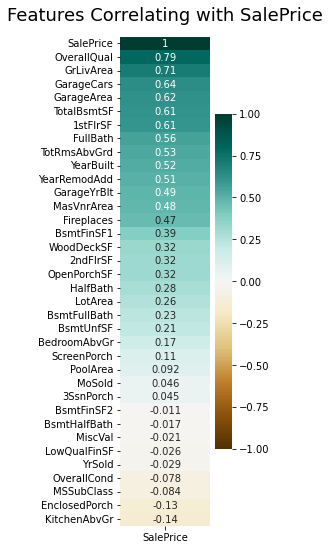

In [331]:
plt.figure(figsize=(2, 9))
heatmap = sns.heatmap(df_num.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), 
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with SalePrice', fontdict={'fontsize':18}, pad=16);

"SalePrice" is highly correlated with "OverallQual" and "GrLivArea" (the first 2 were in the list of possibly relevant features according to the Internet!).

The following heatmap will show the correlation relationships between all the features having more than 0.4 Pearson correlation with "SalePrice".

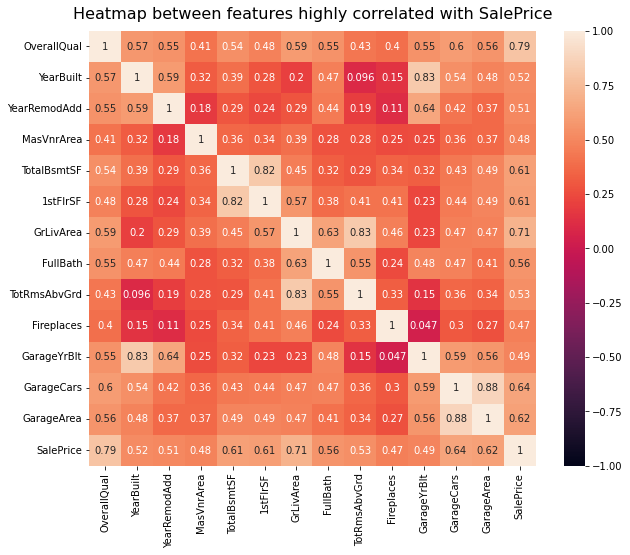

In [332]:
## Names of features highly correlated with SalePrice
highcorr = df_num.corr().loc[df_num.corr()["SalePrice"] > 0.4].index

## Heatmap of features with correlation higher than 0.4 with "SalePrice"
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(df_num[highcorr].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Heatmap between features highly correlated with SalePrice', fontdict={'fontsize':16}, pad=12);

This heatmap shows:
- "GarageArea" and "GarageCars" are both good predictors, but they are highly correlated between them: 0,88. Using both can increase the chance of noise so, as "GarageCars" has higher correlation with "SalePrice", I will keep it.
- "YearBlt" and "GarageYrBlt" have a value of 0,83 (which makes sense, as one would expect most garages to be built at thesame time as the house). "GarageYrBlt" to go. "YearRemoveAdd" also goes: it is highly correlated with "GaraYrBlt", "YearBlt" and "OverallQual".
- The square composed by "FullBath", "TotRmsAbvGrd" and "GrLivArea" is highly correlated. I will keep, then, "GrLivArea".
- "TotalBsmtSF" and "1stFlrSF" have a Pearson value of 0,82. I will keep "TotalBsmtSF".
- "MasVnrArea" could be interesting, as it has some correlation with the target but no with the other features.

After removing the features that I considered would not help, I will print the heatmap again to verify correlations are good now.

In [333]:
df_num.drop(["GarageArea","GarageYrBlt","YearRemodAdd","FullBath","TotRmsAbvGrd","1stFlrSF"], axis=1, inplace=True)

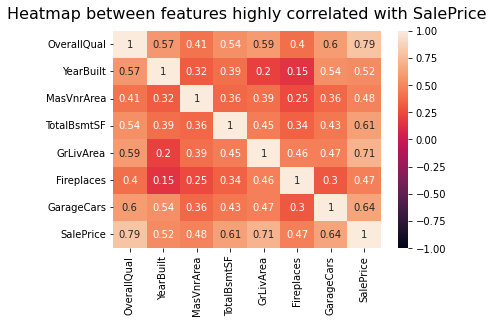

In [334]:
## Names of features highly correlated with SalePrice
highcorr = df_num.corr().loc[df_num.corr()["SalePrice"] > 0.4].index
## Heatmap of features with correlation higher than 0.4 with "SalePrice"
plt.figure(figsize=(6,4))
heatmap = sns.heatmap(df_num[highcorr].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Heatmap between features highly correlated with SalePrice', fontdict={'fontsize':16}, pad=12);

In conclusion, the most promising quantitative features are: "OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF", "YearBuilt", "MasVnrArea" and "Fireplaces". The *describe* method will help getting a better understanding of their values: 

In [335]:
df[["OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF", "YearBuilt", "MasVnrArea","Fireplaces"]].describe()

OverallQual    GrLivArea   GarageCars  TotalBsmtSF    YearBuilt  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean      6.099315  1515.463699     1.767123  1057.429452  1971.267808   
std       1.382997   525.480383     0.747315   438.705324    30.202904   
min       1.000000   334.000000     0.000000     0.000000  1872.000000   
25%       5.000000  1129.500000     1.000000   795.750000  1954.000000   
50%       6.000000  1464.000000     2.000000   991.500000  1973.000000   
75%       7.000000  1776.750000     2.000000  1298.250000  2000.000000   
max      10.000000  5642.000000     4.000000  6110.000000  2010.000000   

        MasVnrArea   Fireplaces  
count  1452.000000  1460.000000  
mean    103.685262     0.613014  
std     181.066207     0.644666  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     1.000000  
75%     166.000000     1.000000  
max    1600.000000     3.000000

- *OverallQual*: Overall Quality. Values from 1 to 10 and mean close to 6.
- *GrLiveArea*: Above ground living area in square feet. The minimum is 334 sq ft and maximum 5642 sq ft, with a mean of 1464 sq ft.
- *GarageCars*: Size of garage in car capacity. Values from 0 to 4, with a median of 2.
- *TotalBsmtSF*: Total square feet of basement area. It has a minimum 0 and a maximum of 6110 sq ft, with an average of 1057 sq ft.
- *YearBuilt*: The earliest house is from 1872, the latest is from 2010 and the average is 1971.
- *MasVnrArea*: Masonry veneer area in square feet. Minimum 0, maximum 1600 sq ft with an average of 104 sq ft.
- *Fireplaces*: Number of fireplaces. Values from 0 to 3, with an average of less than 1.

Time to turn to the qualitative variables:

In [336]:
df_cat.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

A boxplot of "SalePrice" with all these features will provide a general idea of their relationship, and a first glance for good predictors candidates.  

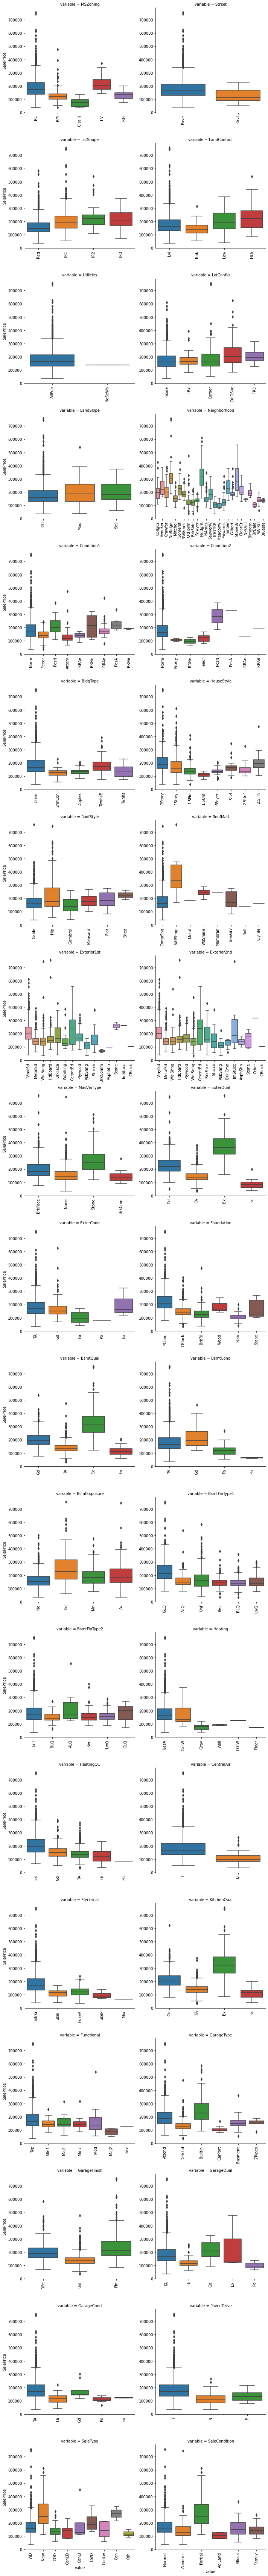

In [337]:
df_t = df
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(df_t, id_vars=['SalePrice'], value_vars=df_cat)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "SalePrice")

Some features that could be useful for our model are:

- "MSZoning": The general zoning classification. It has a total of 5 different classes.
- "Neighborhood": Physical locations within Ames city limits. It has 25 different classes.
- "Exterior1st": Exterior covering on house. It has 15 different classes.
- "ExterQual": Exterior material quality. It has 4 different classes.
- "BsmtQual": Height of the basement. It has 37 NaN values, and a total of 4 different classes.
- "KitchenQual": Kitchen quality. 4 different classes.
- "Foundation": Type of foundation. 6 different classes.
- "HeatingQC": Heating quality and condition. 5 differet classes.
- "GarageType": Type of garage. 81 NaN values and 6 different classes.

To see the correlation between these features and with "SalePrice", the following code will print a Chi-Square test dataframe containing all possible relationships:

In [338]:
cat_var1 = ("MSZoning","Neighborhood","Exterior1st","ExterQual","BsmtQual","KitchenQual","Foundation","HeatingQC","GarageType","SalePrice")
cat_var2 = ("MSZoning","Neighborhood","Exterior1st","ExterQual","BsmtQual","KitchenQual","Foundation","HeatingQC","GarageType","SalePrice")

## Chi-Square test
## Creating all possible combinations between the above two variables list
from itertools import product
cat_var_prod = list(product(cat_var1,cat_var2, repeat = 1))

## Creating an empty variable and picking only the p value from the output of Chi-Square test
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(df[i[0]], df[i[1]])))[1]))

result
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'coeff'])
# Using pivot function to convert the above DataFrame into a crosstab
chi_test_output.pivot(index='var1', columns='var2', values='coeff')

var2               BsmtQual      ExterQual    Exterior1st     Foundation  \
var1                                                                       
BsmtQual                NaN  1.675089e-191   2.443362e-78  1.162252e-144   
ExterQual     1.675089e-191            NaN   1.172291e-95  8.389011e-122   
Exterior1st    2.443362e-78   1.172291e-95            NaN  1.970391e-122   
Foundation    1.162252e-144  8.389011e-122  1.970391e-122            NaN   
GarageType     6.414274e-55   5.601597e-61   4.121825e-43   1.965756e-71   
HeatingQC      1.680163e-62   5.558750e-93   3.373421e-66   4.058347e-97   
KitchenQual   2.066747e-157  6.988390e-277   7.724501e-62  3.671682e-103   
MSZoning       1.143096e-29   3.212044e-49   1.080134e-24   4.071249e-54   
Neighborhood  1.186727e-222  6.512742e-184  8.393905e-238  2.441838e-214   
SalePrice      7.805558e-22   4.250289e-34   9.999839e-01   9.664522e-06   

var2             GarageType     HeatingQC    KitchenQual      MSZoning  \
var1                                                                     
BsmtQual       6.414274e-55  1.680163e-62  2.066747e-157  1.143096e-29   
ExterQual      5.601597e-61  5.558750e-93  6.988390e-277  3.212044e-49   
Exterior1st    4.121825e-43  3.373421e-66   7.724501e-62  1.080134e-24   
Foundation     1.965756e-71  4.058347e-97  3.671682e-103  4.071249e-54   
GarageType              NaN  2.367549e-20   7.078051e-38  1.562724e-45   
HeatingQC      2.367549e-20           NaN   8.180255e-90  2.054007e-13   
KitchenQual    7.078051e-38  8.180255e-90            NaN  6.121037e-25   
MSZoning       1.562724e-45  2.054007e-13   6.121037e-25           NaN   
Neighborhood  5.179038e-100  2.104656e-75  2.720132e-150  0.000000e+00   
SalePrice      1.324831e-01  9.995947e-01   1.282074e-31  4.348325e-11   

var2           Neighborhood     SalePrice  
var1                                       
BsmtQual      1.186727e-222  7.805558e-22  
ExterQual     6.512742e-184  4.250289e-34  
Exterior1st   8.393905e-238  9.999839e-01  
Foundation    2.441838e-214  9.664522e-06  
GarageType    5.179038e-100  1.324831e-01  
HeatingQC      2.104656e-75  9.995947e-01  
KitchenQual   2.720132e-150  1.282074e-31  
MSZoning       0.000000e+00  4.348325e-11  
Neighborhood            NaN  1.364960e-08  
SalePrice      1.364960e-08           NaN

The most promising features are "BsmtQual", "ExterQual","KithenQual", "MSZoning" and "Neighborhood".

When seeing the possible correlations, the fact that "BsmtQual", "ExterQual" and "KithenQual" are all highly correlated (which could also be verified looking at their boxplots): it fits with the fact that when building a house the quality of all areas will be potentially similar - the exception being specific house reforms. To prevent multicollinearity I will stay with the feature that had best parameters of the three: "ExterQual".

"MSZoning" and "Neighborhood" are very highly correlated, with both features being defined according to the location of the house. After some tests, "Neighborhood" proved to be a better predictor, so I will not use "MSZoning".

Finally, these are the winners! For modeling I will use the features:

- Numerical data: 'TotalBsmtSF', 'YearBuilt', 'GrLivArea','MasVnrArea'
- Ordinal data: 'OverallQual','GarageCars','Fireplaces'
- Nominal data:'Neighborhood','ExterQual'

# Preparing the data <a class="anchor" id="preparing"></a>

For this challenge I first plan to use polinomial regression, so I won't transform the data to get linear distributions. For the chosen features, what I want to see is:
- Number of NaN values
- Outliers

Time to look deeper into the relationship between "SalePrices" and these features - bivariate analysis incoming:

#### *TotalBsmtSF*: total square feet of basement area

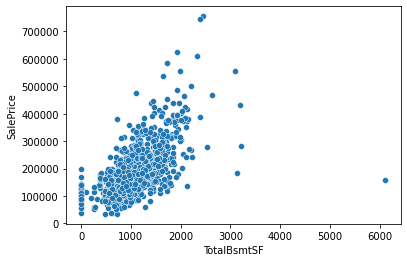

In [339]:
## TotalBsmtSF (total square feet of basement area) and SalePrice
g = sns.scatterplot(data = df, x="TotalBsmtSF", y="SalePrice")

We can see a linear or smooth exponential relationship and one outlier, which is going to be removed:

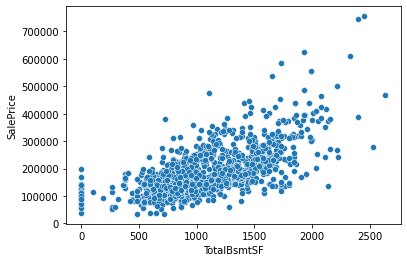

In [340]:
df.drop(df.loc[(df["TotalBsmtSF"] > 3000)].index,inplace=True)
g = sns.scatterplot(data = df, x="TotalBsmtSF", y="SalePrice")

#### *YearBuilt*

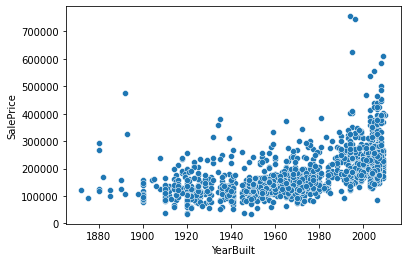

In [341]:
g = sns.scatterplot(data = df, x="YearBuilt", y="SalePrice")

An exponential relationship, with one clear outlier to be removed:

In [342]:
df.drop(df.loc[(df["YearBuilt"] < 1900) & (df["SalePrice"] > 4000)].index,inplace=True)

#### *GrLivArea*: Above ground living area in square feet

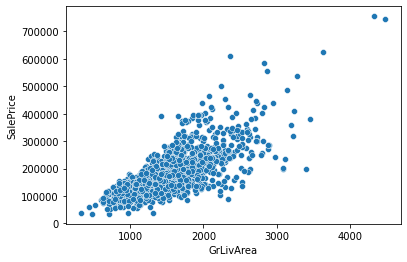

In [343]:
## GrLivArea and SalePrice
g = sns.scatterplot(data = df, x="GrLivArea", y="SalePrice")

The relationship between these variables is linear

#### *MasVnrArea*: Masonry veneer area in square feet

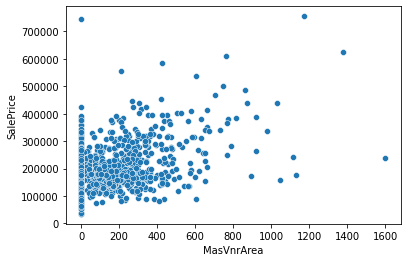

In [344]:
g = sns.scatterplot(data = df, x="MasVnrArea", y="SalePrice")

It has several zero values, and the relationship is not clear - although it looks linear. In later tests it helped to improve the score, so I dedided to keep it.

#### *OverallQual*: Overall Quality

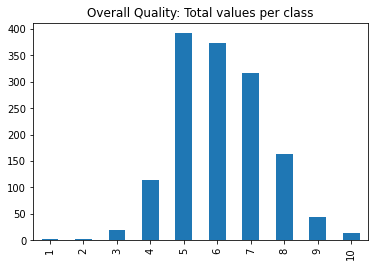

In [345]:
overall = df["OverallQual"].value_counts().sort_index()
g = overall.plot.bar(title="Overall Quality: Total values per class")

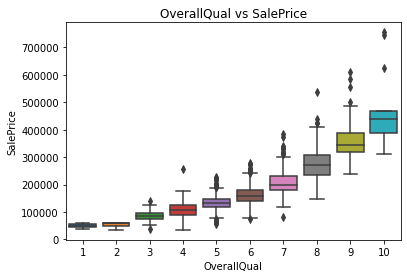

In [346]:
## OverallQual and SalePrice
g = sns.boxplot(data = df, x="OverallQual", y="SalePrice").set(title='OverallQual vs SalePrice')

This feature looks like a very good predictor.

#### *GarageCars*: size of garage in car capacity

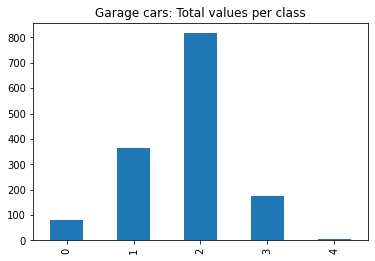

In [347]:
cars = df["GarageCars"].value_counts().sort_index()
g = cars.plot.bar(title="Garage cars: Total values per class")

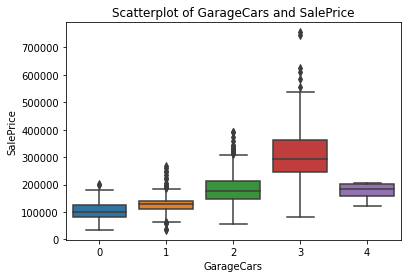

In [348]:
## GarageCars (size of garage in car capacity) and SalePrice
g = sns.boxplot(data = df, x="GarageCars", y="SalePrice").set(title='Scatterplot of GarageCars and SalePrice')

#### Fireplaces

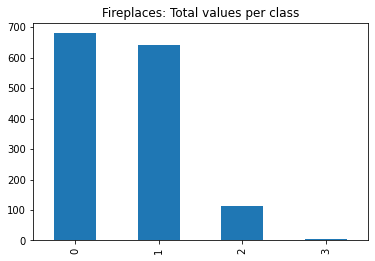

In [349]:
fireplaces = df["Fireplaces"].value_counts().sort_index()
g = fireplaces.plot.bar(title="Fireplaces: Total values per class")

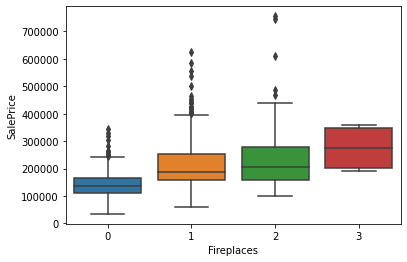

In [350]:
g = sns.boxplot(data = df, x="Fireplaces", y="SalePrice")

#### Neighborhood

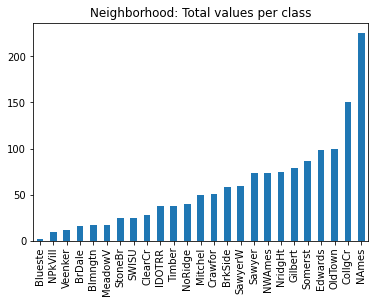

In [351]:
neibh = df["Neighborhood"].value_counts(ascending=True)
g = neibh.plot.bar(title="Neighborhood: Total values per class")

In [ ]:
g = sns.boxplot(data = df, x="Neighborhood", y="SalePrice")
g.tick_params(axis='x', labelrotation=90)

#### ExterQual: Exterior material quality

In [ ]:
ext = df["ExterQual"].value_counts().sort_index()
g = ext.plot.bar(title="Exterior quality: Total values per class")

In [ ]:
g = sns.boxplot(data = df, x="ExterQual", y="SalePrice")

#### Preparing training data

In [ ]:
df_data = df[df["MasVnrArea"].notna()]
df_train = df_data[['TotalBsmtSF','YearBuilt', 'GrLivArea','MasVnrArea']]
df_dummy = df_data[['OverallQual','GarageCars','Neighborhood','Fireplaces','ExterQual']]

for column in df_dummy:
    df_temp = pd.get_dummies(df_data[column], prefix=column)
    df_dummy = pd.concat([df_dummy, df_temp], axis=1)
    df_dummy.drop(column, axis = 1, inplace=True)
    
X_dummy = np.array(df_dummy)
print(f"There are a total of {df_dummy.shape[1]} dummy features")

#### Preparing challenge data

Once the features are chosen, let's see how they behave in the challenge set:

In [ ]:
## Challenge set analysis of its qualitative features
for column in df_challenge[['OverallQual','GarageCars','Neighborhood','Fireplaces','ExterQual']]:
    unique_values = df_challenge[column].unique()
    number_values = len(unique_values)
    if number_values <= 10:
        print(f"The {column} feature has {number_values} values, which are:{unique_values}")
    else :
        print(f"The {column} feature has {number_values} values")

## NaN values of selected features in the challenge set
print(f"\nFeatures have the following number of NaN values:\n{df_challenge[['TotalBsmtSF', 'YearBuilt', 'GrLivArea','OverallQual','GarageCars','Fireplaces','ExterQual']].isnull().sum()}")

df_challenge[['TotalBsmtSF', 'YearBuilt', 'GrLivArea','MasVnrArea','OverallQual','GarageCars','Neighborhood','Fireplaces','ExterQual']].describe()

There are some extra categories in "GarageCars" and in "Fireplaces" that need to be fixed and there is, at least, one very high value in "TotalBsmtSF":

In [ ]:
max5_bsmt = df["TotalBsmtSF"].sort_values(ascending=False)[:5]
max5_bsmt_c = df_challenge["TotalBsmtSF"].sort_values(ascending=False)[:5]

print(f"Top 5 values for TotalBsmtSF in the training set:\n{max5_bsmt}")
print(f"Top 5 values for TotalBsmtSF in the challenge set:\n{max5_bsmt_c}")

In [ ]:
## Replace NaN values
df_challenge["MasVnrArea"] = df_challenge["MasVnrArea"].fillna(0)
df_challenge["GarageCars"] = df_challenge["GarageCars"].fillna(df_challenge["GarageCars"].median())
df_challenge["TotalBsmtSF"] = df_challenge["TotalBsmtSF"].fillna(df_challenge["TotalBsmtSF"].mean())

print(f"Number of NaN after transformation:\n{df_challenge[['TotalBsmtSF', 'YearBuilt', 'GrLivArea','MasVnrArea','OverallQual','GarageCars','Fireplaces']].isnull().sum()}")

## For the one outlier in "TotalBsmtSF", I replace it with a lower value
df_challenge.loc[df_challenge["TotalBsmtSF"] > 3000,"TotalBsmtSF"] = 3000
#df_challenge.loc[df_challenge["GrLivArea"] > 3200,"GrLivArea"] = 3200

## Replace "CarageCars" value of 5 by 4
df_challenge.loc[df_challenge["GarageCars"] == 5,"GarageCars"] = 4
df_challenge["GarageCars"] = df_challenge["GarageCars"].astype(int)

## Replace "Fireplaces" value of 4 by 3
df_challenge.loc[df_challenge["Fireplaces"] == 4,"Fireplaces"] = 3
df_challenge["Fireplaces"] = df_challenge["Fireplaces"].astype(int)

df_challenge["TotalBsmtSF"] = df_challenge["TotalBsmtSF"].astype("int64")

In [ ]:
## Split data into quantitative and qualitative features
df_train_c = df_challenge[['TotalBsmtSF','YearBuilt', 'GrLivArea','MasVnrArea']]
df_dummy_c = df_challenge[['OverallQual','GarageCars','Neighborhood','Fireplaces','ExterQual']]

## Get dummies for qualitative features
for column in df_dummy_c:
    df_temp = pd.get_dummies(df_dummy_c[column], prefix=column)
    df_dummy_c = pd.concat([df_dummy_c, df_temp], axis=1)
    df_dummy_c.drop(column, axis = 1, inplace=True)
X_dummy_c = np.array(df_dummy_c)

## Modelling <a class="anchor" id="modelling"></a>

### Polynomial Regression <a class="anchor" id="polynomial"></a>

This section includes:
- Evaluation of a polynomial regression model in order to find the best regularization parameter (alpha) and optimal degree.
- Plots comparing the evolution of the training set error and testing set error according to the different alpha and degree values. We will measure error with the root mean squared logarithmic error (RMSLE), as explained in the introduction, 
- Learning curve comparing training set error and testing set error with the optimized parameters, as we increase the training set size for the model.
- Printing the model results: the biased term and the weights.
- Histograms in order to compare the prediction and for the "SalePrice" data of the training set.

First, let's find the optimal parameters for the model:

In [ ]:
## Evaluation of linear regression for polinomial features
degree = 6
alpha_list=[30,10,3,1,0.3,0.1,0.03,0.01,0.003,0.001] ## List of alpha values to control the strength of the regularization term
errmsle_train=np.zeros((len(alpha_list),degree-1))
errmsle_test=np.zeros((len(alpha_list),degree-1))

for i in range(1,degree):
    
    ## Transform numerical features into polynomial ones, and then concatenate the dummy variables
    X = np.array(df_train)
    y = np.array(df_data["SalePrice"])

    poly = PolynomialFeatures(i)
    X = poly.fit_transform(X)
    X = np.hstack((X, X_dummy))
    
    ## Feature normalization
    scaler = preprocessing.StandardScaler().fit(X)
    X_norm = scaler.transform(X)
    
    ## Divide data into training set (70%) and test set (30%)
    X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=7)
    
    ## Uncomment to see number of features for each polinomial degree
    #print(f"\nDegree {i}: {X.shape[1]} features")

    for j,alp in enumerate(alpha_list):
        
        mlr = Ridge(alpha=alp,solver='auto')
        mlr.fit(X_train, y_train)

        y_hat_train = mlr.predict(X_train)
        y_hat_test = mlr.predict(X_test)
        y_hat_test = y_hat_test.clip(min=0) # Make zero any negative values in the prediction

        ## Model evaluation: Uncomment to see all root-mean-square error estimations
        #print(f"RMSLE for Alpha = {alp} -> Train set: {np.sqrt(mean_squared_log_error(y_train,y_hat_train)):.04f} Test set: {np.sqrt(mean_squared_log_error(y_test,y_hat_test)):.04f}")
        
        errmsle_train[j][i-1] = np.sqrt(mean_squared_log_error(y_train,y_hat_train))
        errmsle_test[j][i-1] = np.sqrt(mean_squared_log_error(y_test,y_hat_test))
        
## Finding the minimum in the error arrays and printing the most optimized polynomial degree and alpha
flat_min = np.argmin(errmsle_test)
best_value = np.min(errmsle_test)
best_degree = (flat_min%(degree-1))+1
best_alpha = alpha_list[int(np.floor(flat_min/(degree-1)))]
print(f"Best error value is {best_value:.04f}, with polynomial degree = {best_degree} and alpha = {best_alpha}")

The following plots show the evolution of the training and testing sets error when manipulating the alpha value (regularization paremeter) and the degree of the polynomial features. From this graphs we should expect:

- Training error: It will generally keep becoming lower as the training set increases.
- Test error: It is generally high at the beginning (because of underfitting) and it keeps decreasing until reaching a valley, which is the point for the optimal parameters. Then the error will increase as the model starts overfitting. 

The valley point is that place just between underfitting and overfitting the model. 

In [ ]:
fig, ax = plt.subplots(int(np.ceil(len(alpha_list)/2)), 2, figsize=(20,20))
fig.suptitle("Errors for the different Alpha values", fontsize=14)
c = 0
for i in range(0,len(alpha_list)):
    ax[c,i%2].plot(np.arange(1,degree),errmsle_train[i])
    ax[c,i%2].plot(np.arange(1,degree),errmsle_test[i])
    ax[c,i%2].set_title(f"Alpha = {alpha_list[i]}")
    ax[c,i%2].set_xlabel("Polynomial degree")
    ax[c,i%2].set_ylabel("RMSLE")
    ax[c,i%2].legend(["Training error","Test error"])
    fig.tight_layout(pad = 3.)
    if i%2 != 0:
        c = c + 1

#### Learning curve

The following plot shows how, as the training set increases, the training set error and testing set error behaves. It will indicate:
- "Just right"(1 in picture below): Both errors reach very similar values as the samples increase, as these errors are low.
- Underfitting(2): Both errors reach very similar values as the samples increase, but these errors are very high.
- Overfitting(3): The difference between both errors becames smaller as the samples increase, but stays very high at the end.
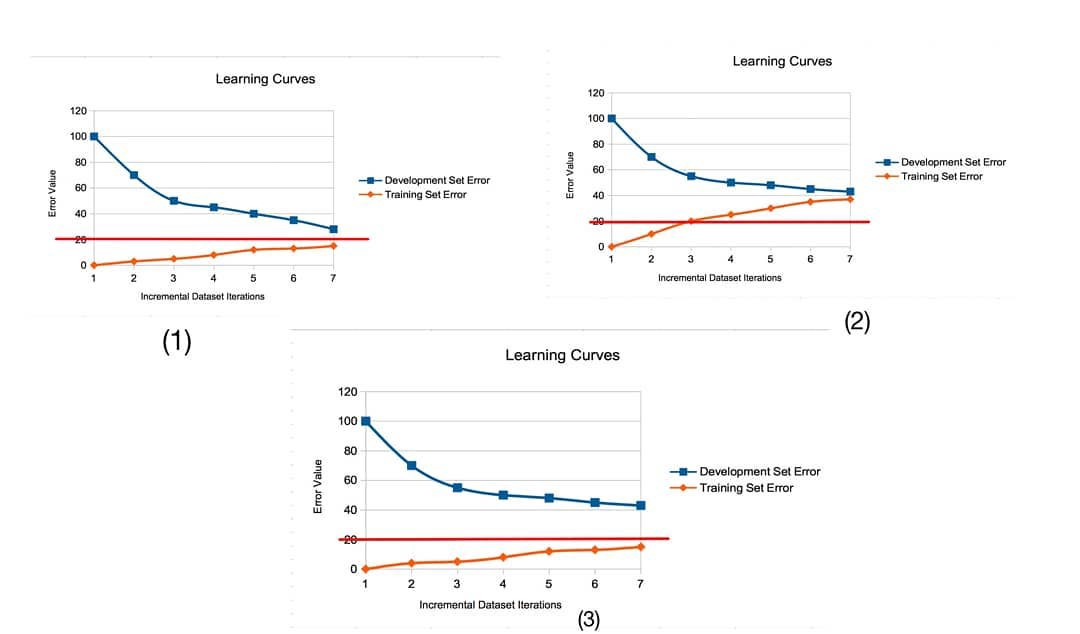

In our case, although the test error varies greatly at the beginning, eventually it stabilizes, improving slowly as the samples increase. The plot does not show overfitting or underfitting, and looks "quite right".

In [ ]:
bins = np.arange(100,1000,10) 
lc_err_train = []
lc_err_test = []

## Feature matrix and targe preparation
X_lc = np.array(df_train)
y_lc = np.array(df_data["SalePrice"])
poly_lc = PolynomialFeatures(best_degree)
X_lc = poly_lc.fit_transform(X_lc)
X_lc = np.hstack((X_lc, X_dummy))
scaler = preprocessing.StandardScaler().fit(X_lc)
X_lc = scaler.transform(X_lc)
    
## Divide data into training set (70%) and test set (30%)
X_train_lc, X_test_lc, y_train_lc, y_test_lc = train_test_split(X_lc, y_lc, test_size=0.3, random_state=7)

## Declaring model class
mlrc_lc = Ridge(best_alpha,solver='auto')

for interval in bins:
    
    ## Fitting the model with a subset of size [0:interval] of the training data 
    mlrc_lc.fit(X_train_lc[:interval], y_train_lc[:interval])
    
    ## RSMLE error for the subset of the training set 
    y_hat_train_lc = mlrc_lc.predict(X_train_lc[:interval])
    y_hat_train_lc = y_hat_train_lc.clip(min=0) # Make zero any negative values in the prediction    
    lc_err_train.append(np.sqrt(mean_squared_log_error(y_hat_train_lc,y_train_lc[:interval])))
    
    # RSMLE error for the whole test set, with the 
    y_hat_test_lc = mlrc_lc.predict(X_test_lc)
    y_hat_test_lc = y_hat_test_lc.clip(min=0) # Make zero any negative values in the prediction    
    lc_err_test.append(np.sqrt(mean_squared_log_error(y_hat_test_lc,y_test_lc)))


plt.figure(figsize=(15,6))
plt.plot(bins,lc_err_train, 'r', label="Train error")
plt.plot(bins,lc_err_test, 'b',label="Test error")
plt.ylim([0,0.8])
plt.title("Learning curve for Polynomial regression")
plt.xlabel("Training set samples")
plt.ylabel("RSMLE")
plt.legend(loc="upper right")
plt.show()

###### Fitting polinomial regression model with optimal parameters

In [ ]:
## Transform numerical features into polinomial ones, and then concatenate the dummy variables
X = np.array(df_train)
y = np.array(df_data["SalePrice"])

## According to the estimations the best results were obtained with best_degree = 5, but when testing with the challenge set,
## actually degree = 2 gave much better results
poly_def = PolynomialFeatures(best_degree)
X = poly_def.fit_transform(X)
X = np.hstack((X, X_dummy))
        
## Feature normalization
scaler = preprocessing.StandardScaler().fit(X)
X_norm = scaler.transform(X)

mlrc = Ridge(alpha=best_alpha,solver='auto')
mlrc.fit(X_norm, y)

## Test the model
y_hat_train2 = mlrc.predict(X_norm)
print(f"Root-mean-squared-log error (RMSLE) for the training set: {np.sqrt(mean_squared_log_error(y_hat_train2,y)):.04f}")

## Printing bias term and weights
print(f"Biased term: {mlrc.intercept_:.02f}")
f = df_train.columns
f = f.append(df_dummy.columns)
fw = zip(f,mlrc.coef_)
df_fw = pd.DataFrame(fw,columns=["Feature","Weight"])
df_fw.transpose()

#### Predictions and exporting them to a csv file

In [ ]:
## Prepare feature matrix X_c
X_c = np.array(df_train_c)
X_c = poly_def.fit_transform(X_c)
X_c = np.hstack((X_c, X_dummy_c))

## Feature normalization
scaler = preprocessing.StandardScaler().fit(X_c)
X_c = scaler.transform(X_c)

#print(f"Checking number of features\nTraining matrix X: {X.shape[1]}\nX_challenge matrix: {X_c.shape[1]}")
## Prediction values
y_hat_poly = mlrc.predict(X_c)

## Export predictions in a csv file
id_c = [i for i in range(1461,2920)]
pred_poly = zip(id_c,y_hat_poly)
df_pred_poly = pd.DataFrame(pred_poly,columns=["Id","SalePrice"]).set_index("Id")
df_pred_poly.to_csv("HousePrices_solution_polynomial.csv")

In [ ]:
h = sns.histplot(y_hat_poly).set_title("Distribution of prediction")

In [ ]:
h = sns.histplot(data=df_houses, x="SalePrice").set_title("Distribution of original data")

### Random forest <a class="anchor" id="random"></a>

In [ ]:
## Preparing training data. No normalization required for this model
X_rf = np.array(df_train)
X_rf = np.hstack((X_rf, X_dummy))
y_rf = np.array(df_data["SalePrice"])

In [ ]:
rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', max_depth = 10, random_state = 7)

In [ ]:
## Fit random forest with training data
rf.fit(X_rf, y_rf)

## Estimate predictions for the challenge data
Xc_rf = np.array(df_train_c)
Xc_rf = np.hstack((Xc_rf, X_dummy_c))
print(Xc_rf.shape)
y_hat_rf = rf.predict(Xc_rf)

## Error of the training data
pred_test_rf = rf.predict(X_rf)
rf_rmsle = np.sqrt(mean_squared_log_error(y,pred_test_rf))
print(f"Root-mean-squared-log error (RMSLE) for the training set: {rf_rmsle:.04f}")

# Save csv file with predictions
pred_rf = zip(id_c,y_hat_rf)
df_pred_rf = pd.DataFrame(pred_rf,columns=["Id","SalePrice"]).set_index("Id")
df_pred_rf.to_csv("HousePrices_solution_randomforest.csv")

Remove quotation marks to run GridSearch test:

In [ ]:
"""
random_forest_tuning = RandomForestRegressor(random_state = 7)
param_grid = {
   'n_estimators': [100,200,300,400,500],
   'max_features': ['sqrt', 'log2'],
   'max_depth' : [3,4,5,6,7,8,9,10],
   'criterion' :['squared_error']
}
GSCV = GridSearchCV(estimator=random_forest_tuning, param_grid=param_grid, cv=5)
GSCV.fit(X_rf, y)
GSCV.best_params_
"""

Results:

{'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 500}

In order to see the result, the following plot shows 200 points of the training data target and the prediction: we can generally see how the algorithm is a bit conservative in its predictions, trying not to go very high or low for each sample.

In [ ]:
## Plotting results
plt.figure(figsize=(15,8))
plt.scatter(range(0,200), y_rf[:200], color = 'red', label = "Training data")
plt.scatter(range(0,200), pred_test_rf[:200], color = 'green', label = "Prediction of training data")
plt.title('Random Forest Regression')
plt.xlabel("Sample ID")
plt.ylabel('SalePrice')
plt.legend()
plt.show() 